RMSProp  
VGG16  
Xception  
Dropout  
LR  
image size

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

sns.set_context('notebook')
sns.set_style('white')

In [2]:
classes = ['NORMAL', 'PNEUMONIA']

IMG_HEIGHT, IMG_WIDTH = 256, 256 # try 256
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/val'

#### EDA

Check for data imbalance

In [3]:
train_normal_num_files = len(list(Path(train_dir + '/' + classes[0]).glob('*.jpeg')))
train_pneumonia_num_files = len(list(Path(train_dir + '/' + classes[1]).glob('*.jpeg')))

<Axes: >

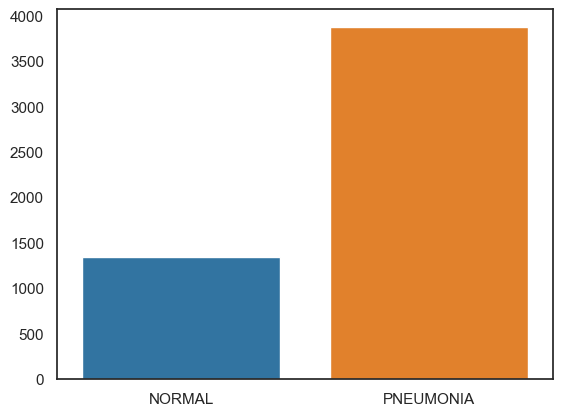

In [4]:
sns.barplot(
    x=classes,
    y=[train_normal_num_files, train_pneumonia_num_files],
    hue=classes
)

As we can see, there are almost 3 times more Pneumonia images than normal ones.

#### Load dataset

`image_dataset_from_directory` generates a tf.data.Dataset from image files in a directory.

If your directory structure is:

    main_directory/
    ...class_a/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...class_b/
    ......b_image_1.jpg
    ......b_image_2.jpg
Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    color_mode='rgb',
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode='rgb',
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode='rgb',
)


Found 5216 files belonging to 2 classes.
Found 60 files belonging to 2 classes.
Found 580 files belonging to 2 classes.


#### Augment data

##### Benefits of Using the tf.keras.layers Augmentation Layer

**1. On-the-fly augmentation during training**  
- Augmentations are applied dynamically during training, which means:
    - No extra disk space is needed for augmented images.
    - The model sees new variations every epoch, improving generalization.
- It helps simulate a larger, more diverse dataset without manual duplication.

**2. GPU-accelerated and built into the TensorFlow graph**
- These layers run as part of the TensorFlow computational graph, meaning:
    - They’re fast and optimized for GPUs/TPUs.
    - No slow, CPU-bound Python loops or I/O bottlenecks.
- Ideal for large-scale training pipelines.

In [6]:
# Use Keras layers as augmentations
# This is a simple augmentation pipeline that includes random flipping, rotation, zooming, and contrast adjustment.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])  

def augment(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]
    image = data_augmentation(image)
    return image, label

def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]
    return image, label

# Apply the augmentation to the training dataset
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

# Normalize the validation and test datasets
val_ds = val_ds.map(normalize, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(normalize, num_parallel_calls=AUTOTUNE)


#### Prefetch data for performance

`prefetch()` allows the data loading and model training to run in parallel.

Without prefetching, the workflow looks like this — sequential and slower:

- Load a batch of data
- Train on that batch
- Load the next batch
- Train again
(Repeat...)

This means the GPU waits while the CPU loads data — wasted time!

With `prefetch(buffer_size=N)`, TensorFlow starts loading the next N batches in the background while the model is training on the current batch.
So the steps overlap like this:

- While training on batch A, the pipeline is loading batch B
- When batch A is done, batch B is ready instantly  

`tf.data.AUTOTUNE` lets TensorFlow decide the optimal buffer size dynamically.






In [7]:
# Prefetch for performance
# This allows later batches to be prepared while the current one is being processed
# This will speed up training
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

#### Compute Class Weights

**Why Use Class Weights?**  
When the dataset is imbalanced (e.g., many more "Normal" than "Pneumonia" X-rays), the model can get high accuracy by just predicting the majority class all the time.

Imagine this:
- 90% Normal
- 10% Pneumonia

A model that always predicts "Normal" would have 90% accuracy, but 0% recall for Pneumonia — which is unacceptable in medical diagnostics.

So, to combat this imbalance, class weights adjust the importance of each class when calculating the loss.

**What Do Class Weights Do, Mathematically?**  
In a standard loss like binary cross-entropy, each example contributes equally. But with class weights, the contribution to the loss is scaled:

Binary Cross-Entropy (with weights):  
Loss = −𝑤1 ⋅ 𝑦 ⋅ log(𝑦^) − 𝑤0 ⋅ (1 − 𝑦) ⋅ log(1 − 𝑦^)

Where:
- 𝑦 is the true label
- 𝑦^ is the predicted probability
- 𝑤1, 𝑤0 are weights for class 1 and 0, respectively

This makes mistakes on minority class samples "hurt more" in training, nudging the model to learn their features better.

In [8]:
# Get all training labels
y_train = np.concatenate([y for x, y in train_ds], axis=0)

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [9]:
basemodel = tf.keras.applications.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# basemodel.trainable = False
# for layer in basemodel.layers: layer.trainable = False 

basemodel.trainable = True
for layer in basemodel.layers[:-2]:  # Let trainable only last n layers
    layer.trainable = False

input_shape = basemodel.output_shape[1]
model = Sequential([
    basemodel,

    # tf.keras.layers.GlobalAveragePooling2D(),  # Global average pooling layer to reduce the spatial dimensions
    # tf.keras.layers.BatchNormalization(),  # Normalize the output
    # tf.keras.layers.Dropout(0.2),  # Add dropout for regularization

    tf.keras.layers.Flatten(),   # Flatten the output of the base model
    # tf.keras.layers.BatchNormalization(),  # Normalize the output
    # tf.keras.layers.Dropout(0.2),  # Add dropout for regularization

    tf.keras.layers.Dense(1024, activation='relu'),  # Add a fully connected layer

    # tf.keras.layers.Dense(256, activation='relu'),  # Add a fully connected layer
    # tf.keras.layers.BatchNormalization(),  # Normalize the output
    # tf.keras.layers.Dropout(0.2),  # Add dropout for regularization

    # tf.keras.layers.Dense(256, activation='relu'),  # Add a fully connected layer
    # tf.keras.layers.BatchNormalization(),  # Normalize the output
    # tf.keras.layers.Dropout(0.2),  # Add dropout for regularization

    tf.keras.layers.Dense(128, activation='relu'),  # Add a fully connected layer
    # tf.keras.layers.BatchNormalization(),  # Normalize the output
    # tf.keras.layers.Dropout(0.2),  # Add dropout for regularization
    
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 48,401,473
Trainable params: 36,046,593
Non-trainable params: 12,354,880
_________________________________________________________________


In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy', 
                    #    tf.keras.metrics.Precision(name='precision'), 
                    #    tf.keras.metrics.Recall(name='recall')
                       ])

In [11]:
early_stopping = EarlyStopping(monitor='val_accuracy', # You can also use 'val_recall' or 'val_precision'
                               patience=7, # Wait n epochs before stopping if no improvement
                               verbose=1,
                               restore_best_weights=True)

learning_rate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,  # Reduce learning rate by factor
    patience=2,  # Wait n epochs before reducing the learning rate if no improvement
    verbose=1,
    min_lr=1e-6  # Minimum learning rate
)
# Train the model

In [12]:
# Fit the model
history = model.fit(train_ds, 
                    epochs=20,
                    validation_data=val_ds,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, learning_rate_scheduler],
                    batch_size=BATCH_SIZE,)  

Epoch 1/20
652/652 [==============================] - 76s 105ms/step - loss: 0.5097 - accuracy: 0.7030 - val_loss: 0.6410 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 2/20
652/652 [==============================] - 67s 102ms/step - loss: 0.4503 - accuracy: 0.7232 - val_loss: 0.4536 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 3/20
652/652 [==============================] - 68s 103ms/step - loss: 0.4340 - accuracy: 0.7312 - val_loss: 0.8211 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 4/20
652/652 [==============================] - ETA: 0s - loss: 0.4222 - accuracy: 0.7558
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
652/652 [==============================] - 67s 103ms/step - loss: 0.4222 - accuracy: 0.7558 - val_loss: 1.0857 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 5/20
652/652 [==============================] - 68s 104ms/step - loss: 0.4042 - accuracy: 0.6722 - val_loss: 0.3744 - val_accuracy: 0.8333 - lr: 5.0000e-05
Epoch 6/20
652/652 [=========

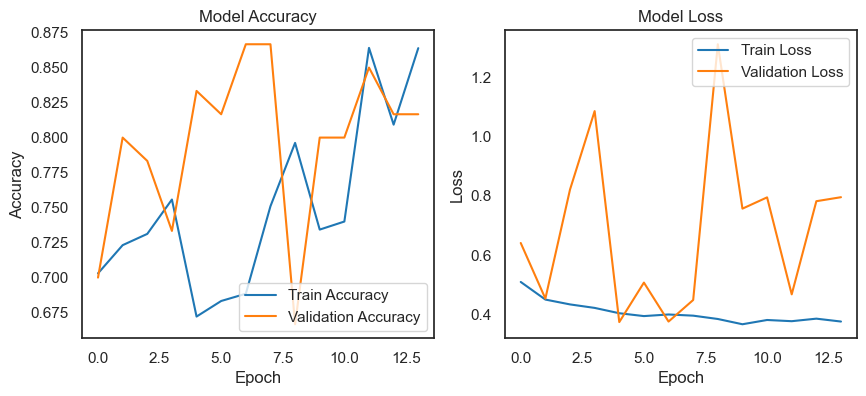

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='lower right')

ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')
plt.show()

In [14]:
model.evaluate(test_ds)

73/73 [==============================] - 6s 82ms/step - loss: 0.2745 - accuracy: 0.9052


[0.2744990587234497, 0.9051724076271057]

In [15]:
# basemodel.trainable = True
# for layer in basemodel.layers[:-5]:  # Fine-tune last n layers
#     layer.trainable = False

# model.summary()

In [16]:
# model.compile(loss='binary_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(1e-5),
#               metrics=['accuracy', 
#                     #    tf.keras.metrics.Precision(name='precision'), 
#                     #    tf.keras.metrics.Recall(name='recall')
#                        ])

# history_fine_tunned = model.fit(train_ds, 
#                     epochs=20,
#                     validation_data=val_ds,
#                     class_weight=class_weight_dict,
#                     callbacks=[early_stopping, learning_rate_scheduler],
#                     batch_size=BATCH_SIZE,)  

In [17]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# ax[0].plot(history_fine_tunned.history['accuracy'], label='Train Accuracy')
# ax[0].plot(history_fine_tunned.history['val_accuracy'], label='Validation Accuracy')
# ax[0].set_title('Model Accuracy')
# ax[0].set_ylabel('Accuracy')
# ax[0].set_xlabel('Epoch')
# ax[0].legend(loc='lower right')

# ax[1].plot(history_fine_tunned.history['loss'], label='Train Loss')
# ax[1].plot(history_fine_tunned.history['val_loss'], label='Validation Loss')
# ax[1].set_title('Model Loss')
# ax[1].set_ylabel('Loss')
# ax[1].set_xlabel('Epoch')
# ax[1].legend(loc='upper right')
# plt.show()

In [18]:
# model.evaluate(test_ds)

#### Misclassifications

In [19]:
y_true = []
y_pred = []
images = []

for batch_images, batch_labels in test_ds:
    preds = model.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())
    images.extend(batch_images.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)   
images = np.array(images)


1/1 [==============================] - 0s 20ms/step


In [20]:
print(metrics.classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.95      0.78      0.86       212
   PNEUMONIA       0.89      0.98      0.93       368

    accuracy                           0.91       580
   macro avg       0.92      0.88      0.89       580
weighted avg       0.91      0.91      0.90       580



In [21]:
misclassified_idxs = np.where(y_true != y_pred)[0]  # Get the indices of misclassified images
print(f"Total misclassified images: {len(misclassified_idxs)}")

Total misclassified images: 55


In [22]:
normal_misclassified = np.sum(y_true[misclassified_idxs] == 0)
pneumonia_misclassified = np.sum(y_true[misclassified_idxs] == 1)
print(f"Normal misclassified: {normal_misclassified}")
print(f"Pneumonia misclassified: {pneumonia_misclassified}")

Normal misclassified: 46
Pneumonia misclassified: 9
